# week 6

## goals:
- meet with Dan & Ray to determine next steps

## todo

- ~another sanity check - plot just the points that are inside MPAs (use the joined points table before aggregation)~
- ~remember to check GFW for an MPA layer~
- think about going back to boxes instead of points (might slow it down unnecessarily actually)
- ~make a list of mpas from Tim White's paper -- check fishing hours in those places~
    - these don't have much
- make a plot where the MPAs are colored by fishing hours?
    
- using just those mpas, do the join in a way that preserves mmsi
- make a table keyed my mmsi, of effort in each mpa, plus effort in none?


## notes:

- specifically try to answer:
    - "you might want to just focus on MPAs that are beyond the continental shelves but we can talk about that."
        - focus on high seas
    - Should I include things like Ross Sea (which probably have a terrestrial component as well)?
    - How do I use the post-2016 data? I'm in the google [permission?] group – can I make queries against an API?
        - offline meeting with Dan to pull this data

- GFW Data Training <- this is the google group to get added to


- explicit theories about how they should behave and testing that

- Ross Sea
- PIPA
- PMNM
- south/central pacific ocean
- pick out the 5 from Tim White's paper:
    - PIPA - 2010
    - Pacific Remote Islands - 2009
    - PMNM - yes but low fishing effort (3258 hours, 2016)
    - Pitcairn Islands - yes but low (101 hours, 2016)
    - Nazca-Desventuradas - yes but low (68 hours, 2016)
    
Actual good ones:
- Natural Park of the Coral Seas, 2014 555577562, further off the east coast of Australia
- Marae Moana, 2017 555624907 - maybe the best one - middle of the Pacific
- French Austral Lands and Seas, 2019 555697868 - south-east of Africa
- Arquipélago Submarino Do Meteor, 2016 555514087 - Atlantic ocean Y shaped area
- Coral Sea, 2018 555556875 just off the east coast of Australia
- Pacífico Mexicano Profundo, 2018 555624307 southwest Mexican coast


Can't use:
- Phoenix Island - it's 2010


A bunch of these at the top are coastal around Spain/France:
- Espacio marino del Delta de l'Ebre-Illes Columbretes 2014
- Espacio marino de la Costa da Morte 2014
- Pertuis charentais - Rochebonne 2019




In [22]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
import pretty_html_table

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

In [84]:
# reads the downloaded WPDA polygon files
filenames = [
    "data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp0/WDPA_WDOECM_wdpa_shp-polygons.shp",
    "data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp1/WDPA_WDOECM_wdpa_shp-polygons.shp",
    "data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp2/WDPA_WDOECM_wdpa_shp-polygons.shp",
]
protected_areas = []
counted = 0
for filename in filenames:
    print(f'\r{counted}/{len(filenames)} {filename}', end='')
    protected_areas.append(geopandas.read_file(filename))
    counted += 1
    
protected_areas = pandas.concat(protected_areas)
# filters for marine only (may want to change this to 1 or 2 (2 is marine only, 1 is mixed, 0 is terrestrial))
mpas = protected_areas[protected_areas["MARINE"] == "2"]
# delete the larger table - it's like 3 GiB and not needed past this point
del(protected_areas)

2/3 data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp2/WDPA_WDOECM_wdpa_shp-polygons.shp

In [4]:
## Load the fishing hours data (this is kinda slow)
filenames = os.listdir('data/daily_csvs')

# this might be faster but the status printout is nice:
# points = pandas.concat([geopandas.read_file('data/daily_csvs/' + filename) for filename in filenames])

counted = 0
points = []
for filename in filenames:
    print(f'\r {filename} {counted}/{len(filenames)}', end='')
    points.append(pandas.read_csv('data/daily_csvs/' + filename,
                                      dtype={'lat_bin': 'int16',
                                             'lon_bin': 'int16',
                                             'mmsi': 'int32',
                                             'fishing_hours': 'float32'},
                                 parse_dates=['date']))
    counted += 1
points = pandas.concat(points) # deliberately overwriting points

 2013-12-20.csv 1826/1827

In [6]:
## Aggregate the points and bin them
points_ = points.groupby(['lat_bin', 'lon_bin']).aggregate({'lat_bin': 'first', 'lon_bin': 'first', 'fishing_hours': 'sum'})
points_['lat'] = (points_['lat_bin'] * 0.1 + 0.05).astype('float')
points_['lon'] = (points_['lon_bin'] * 0.1 + 0.05).astype('float')
geopoints = geopandas.GeoDataFrame(
    points_,
    geometry=geopandas.points_from_xy(points_['lon'], points_['lat'])
).set_crs(epsg=4326)


In [85]:
# Produce ranked list of mpas by amount of effort inside their borders
# q - should we join by id or something first?

joined_points = geopandas.sjoin(geopoints, mpas, op='intersects')


Text(0.5, 1.0, 'fishing hours inside mpas 2012-2016 in 0.1 degree aggregate')

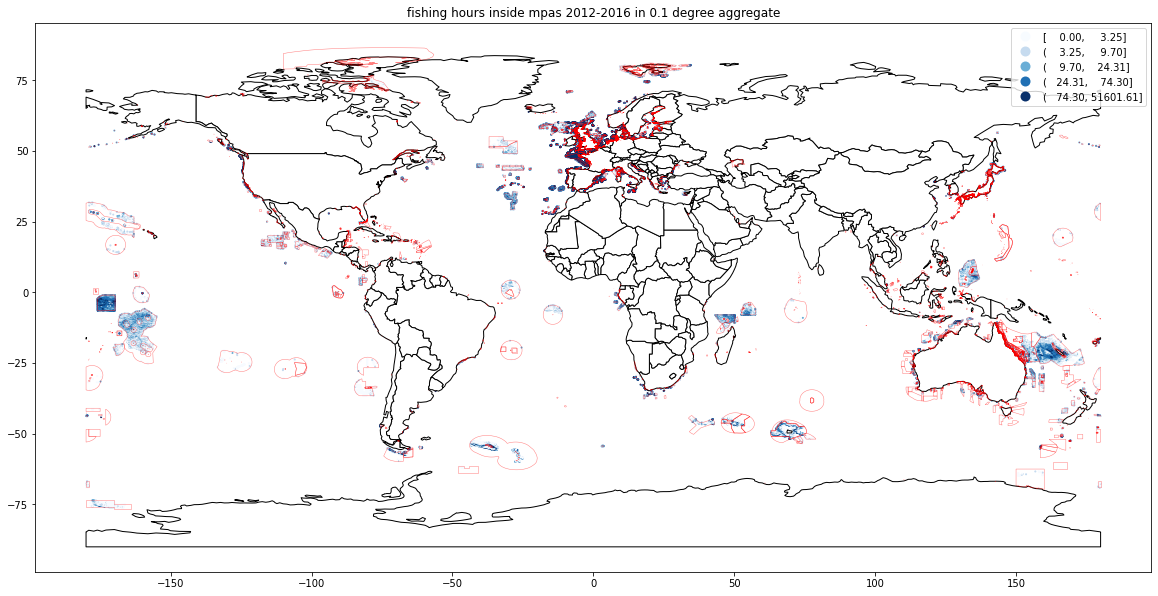

In [14]:
## Plot
ax = joined_points.plot(column='fishing_hours', figsize=(20, 30), markersize=1, cmap='Blues', scheme='quantiles', legend=True)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black', ax=ax, )

LINEWIDTH = 0.5
mpas.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH, alpha=0.5)

plt.title('fishing hours inside mpas 2012-2016 in 0.1 degree aggregate')

In [86]:
def string_join(strings):
    base = strings.iloc[0] if strings.any() else ''
    for s in strings[1:]:
        base = base if s in base else base + '|' + s
    return base


joined_points_aggregate = joined_points.groupby(['WDPAID'], as_index=False).aggregate({
    'NAME': string_join,
    'fishing_hours': 'sum',
    'STATUS_YR': 'first',
    'REP_M_AREA': 'sum',
    'REP_AREA': 'sum',
    'NO_TAKE': string_join,
})

sorted_mpas = joined_points_aggregate.sort_values("fishing_hours", ascending=False)

In [172]:
## Filter by year and fishing hours,
mpas_ = sorted_mpas[sorted_mpas['STATUS_YR'] >= 2014]
mpas_ = mpas_[mpas_['STATUS_YR'] < 2020]

duplicates = [
    1195, 1203, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1202, 1505, 1200, 1198,
    1485, 1199, 1243, 1246, 1245, 996, 993, 1241, 997, 980, 987, 994, 1240, 1003, 999, 992, 
]
mpas_ = mpas_.drop(duplicates)
mpas_ = mpas_[mpas_['fishing_hours'] > 5000]
print(mpas_.info())
mpas_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1543 to 1593
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WDPAID         113 non-null    float64
 1   NAME           113 non-null    object 
 2   fishing_hours  113 non-null    float32
 3   STATUS_YR      113 non-null    int64  
 4   REP_M_AREA     113 non-null    float64
 5   REP_AREA       113 non-null    float64
 6   NO_TAKE        113 non-null    object 
dtypes: float32(1), float64(3), int64(1), object(2)
memory usage: 6.6+ KB
None


,WDPAID,NAME,fishing_hours,STATUS_YR,REP_M_AREA,REP_AREA,NO_TAKE
1543,555643633.0,Mers Celtiques - Talus du golfe de Gascogne,787984.562500,2018,0.000000e+00,6.086622e+07,Not Reported
1254,555593060.0,Espacio marino del Delta de l'Ebre-Illes Colum...,340408.718750,2014,0.000000e+00,8.836744e+05,Not Reported
1154,555583117.0,Espacio marino de la Costa da Morte,285951.500000,2014,1.169940e+05,1.169940e+05,Not Reported
577,555539414.0,Pertuis charentais - Rochebonne,267298.406250,2019,0.000000e+00,7.209470e+05,Not Reported
1157,555583120.0,Golfo de Cadiz,249384.421875,2014,5.322200e+04,5.322200e+04,Not Reported
1437,555624872.0,Southern North Sea,220620.968750,2017,1.852798e+07,1.852798e+07,Not Reported
1206,555589788.0,Estuaire De La Gironde Et Mer Des Pertuis,219721.796875,2015,0.000000e+00,4.485000e+05,Not Reported
1434,555624866.0,Inner Hebrides and the Minches,177346.828125,2017,2.804039e+06,2.804039e+06,Not Reported
1050,555577562.0,Natural Park of the Coral Sea,167314.937500,2014,7.790096e+09,7.790126e+09,Part
1156,555583119.0,Espacio marino de las Rias Baixas de Galicia,156711.718750,2014,5.545000e+04,5.545000e+04,Not Reported


In [173]:
reprint = True
if reprint:
    f = open("at_least_5000_fishing_hours.html", "w")
    f.write(pretty_html_table.build_table(mpas_, 'blue_light'))
    f.close()

In [125]:
## redo the join using only the interesting mpas
wdpaids = mpas_['WDPAID']
mpas_in_list = mpas[mpas['WDPAID'].isin(wdpaids)]

joined_points_in_list = geopandas.sjoin(geopoints, mpas_in_list, op='intersects')


In [166]:
m_ = mpas_in_list.merge(mpas_, on='WDPAID').sort_values("fishing_hours", ascending=False)

Text(0.5, 1.0, 'mpas with >=5,000 fishing hours 2012-2016 that closed 2014-2019')

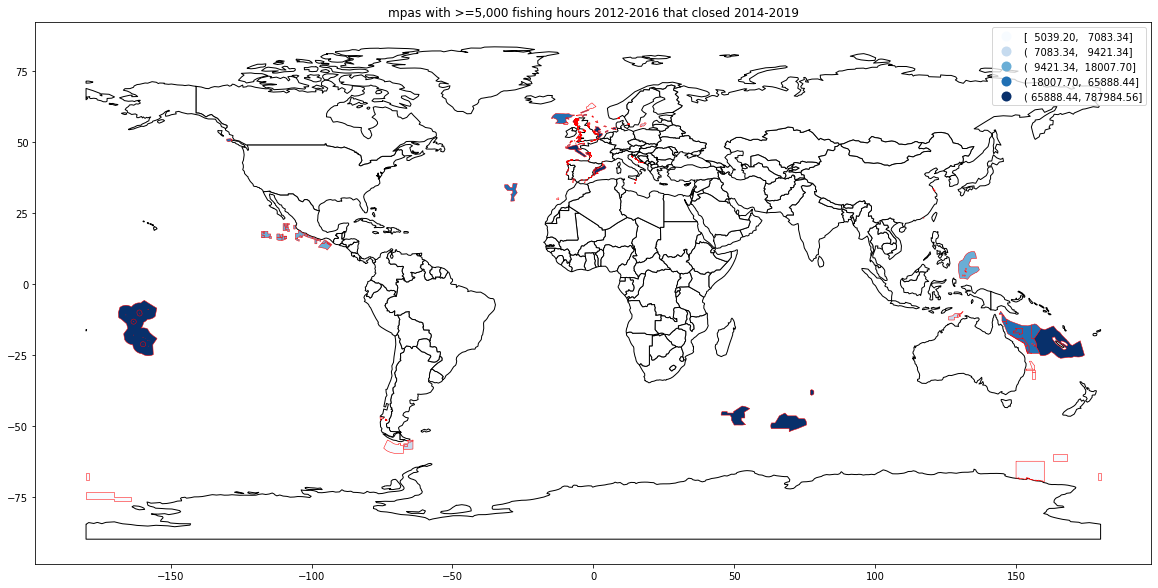

In [171]:
## Plot
#ax = joined_points_in_list.plot(column='fishing_hours', figsize=(20, 30), markersize=1, cmap='Blues', scheme='quantiles', legend=True)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black', figsize=(20, 30))

LINEWIDTH = 0.5
m_.plot(ax=ax, column='fishing_hours', edgecolor='red', linewidth=LINEWIDTH, scheme='quantiles', cmap='Blues', legend=True)

plt.title('mpas with >=5,000 fishing hours 2012-2016 that closed 2014-2019')